In [114]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [4]:
def load_events(file_path):
    data = np.loadtxt(file_path, delimiter=',', skiprows=2)
    return data[:, [0, 1, 3]]


In [5]:
def visualize_events(data):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Time (s)')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Event Camera Data Visualization')
    plt.grid(True)
    plt.show()

# Data Package 1

In [127]:
def calculate_relative_pose(events):
    image_width = 640
    image_height = 480
    focal_length = 320

    u0 = image_width / 2
    v0 = image_height / 2

    normalized_coords = np.zeros((events.shape[0], 3))
    normalized_coords[:, 0] = (events[:, 0] - u0) / focal_length
    normalized_coords[:, 1] = (events[:, 1] - v0) / focal_length
    normalized_coords[:, 2] = 1  # homogeneous coordinates

    time_diffs = events[:, 2] - 0  # ts = 0
    time_diffs = time_diffs.reshape(-1, 1)

    A = np.hstack([time_diffs * normalized_coords, normalized_coords])

    U, S, Vt = np.linalg.svd(A)
    x_hat = Vt[-1, :] 

    e_l2 = x_hat[3:6]
    u_lz = np.dot(x_hat[:3], x_hat[3:6])
    u_ly_e_l1 = np.cross(x_hat[:3], x_hat[3:6])
    u_ly = np.linalg.norm(u_ly_e_l1)
    e_l1 = u_ly_e_l1 / u_ly
    e_l3 = np.cross(e_l1, e_l2)

    u_l = [0, u_ly, u_lz]
    R_l = np.vstack([e_l1, e_l2, e_l3]).T
    return u_l, R_l


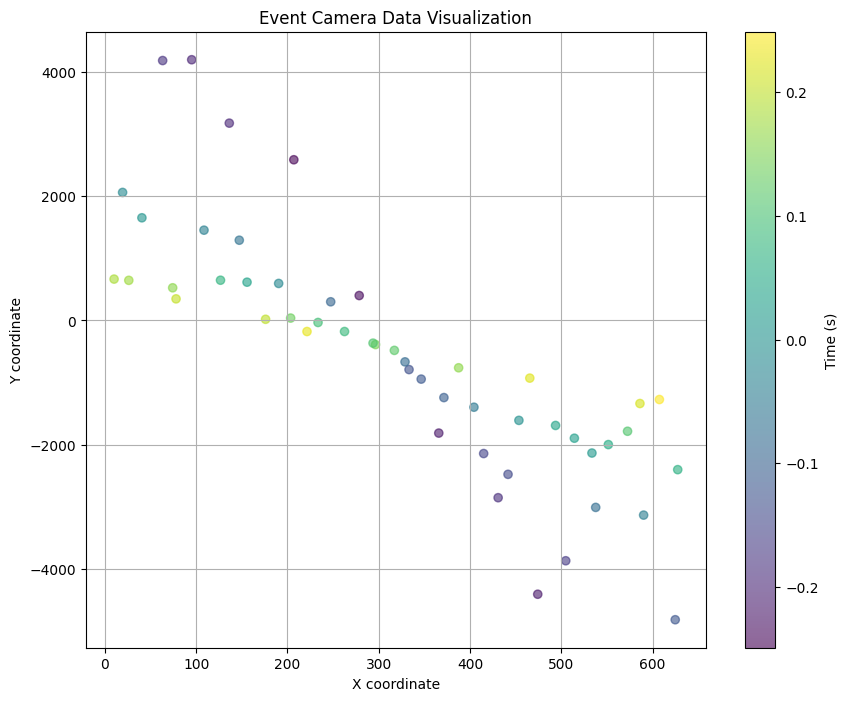

In [128]:
events_1 = load_events("hw5_data/data_package1.txt")
visualize_events(events_1)

In [130]:
result_1 = calculate_relative_pose(events_1)
result_1

([0, 0.2654219190125011, -0.33114332602488694],
 array([[ 0.01385558, -0.46163869, -0.14989091],
        [ 0.90567943, -0.05773239,  0.19753212],
        [-0.42373671, -0.13849004,  0.41729675]]))

# Data Package 2

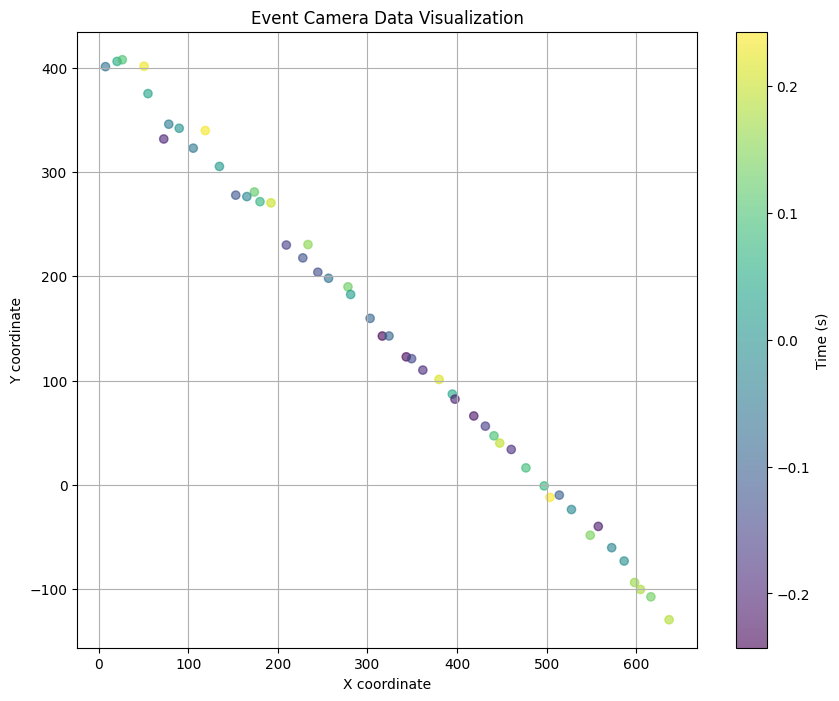

In [115]:
events_2 = load_events("hw5_data/data_package2.txt")
visualize_events(events_2)

In [125]:
def calculate_relative_pose(events):
    image_width = 640
    image_height = 480
    focal_length = 320

    u0 = image_width / 2
    v0 = image_height / 2
    
    angular_velocity = np.array([-0.242109, 0.0857362, 0.0507106])

    normalized_coords = np.zeros((events.shape[0], 3))
    normalized_coords[:, 0] = (events[:, 0] - u0) / focal_length
    normalized_coords[:, 1] = (events[:, 1] - v0) / focal_length
    normalized_coords[:, 2] = 1  # homogeneous coordinates

    time_diffs = events[:, 2] - 0  # ts = 0
    vs = np.array([np.array(angular_velocity)*time_diffs[i] for i in range(time_diffs.shape[0])])
    for i in range(vs.shape[0]):
        rot, _ = cv2.Rodrigues(vs[i])
        normalized_coords[i] = (rot @ normalized_coords[i].T).T
    
    time_diffs = time_diffs.reshape(-1, 1)

    A = np.hstack([time_diffs * normalized_coords, normalized_coords])

    U, S, Vt = np.linalg.svd(A)
    x_hat = Vt[-1, :]  # Solution corresponding to the smallest singular value

    e_l2 = x_hat[3:6]
    u_lz = np.dot(x_hat[:3], x_hat[3:6])
    u_ly_e_l1 = np.cross(x_hat[:3], x_hat[3:6])
    u_ly = np.linalg.norm(u_ly_e_l1)
    e_l1 = u_ly_e_l1 / u_ly
    e_l3 = np.cross(e_l1, e_l2)

    u_l = [0, u_ly, u_lz]
    R_l = np.vstack([e_l1, e_l2, e_l3]).T
    return u_l, R_l

In [126]:
result_2 = calculate_relative_pose(events_2)
result_2

([0, 0.3169719343441662, 0.16684114324912142],
 array([[ 0.67654048, -0.57687807,  0.35711956],
        [-0.65838032, -0.69107337, -0.05760464],
        [ 0.32989141, -0.19614862, -0.84734427]]))

# Data Package 3

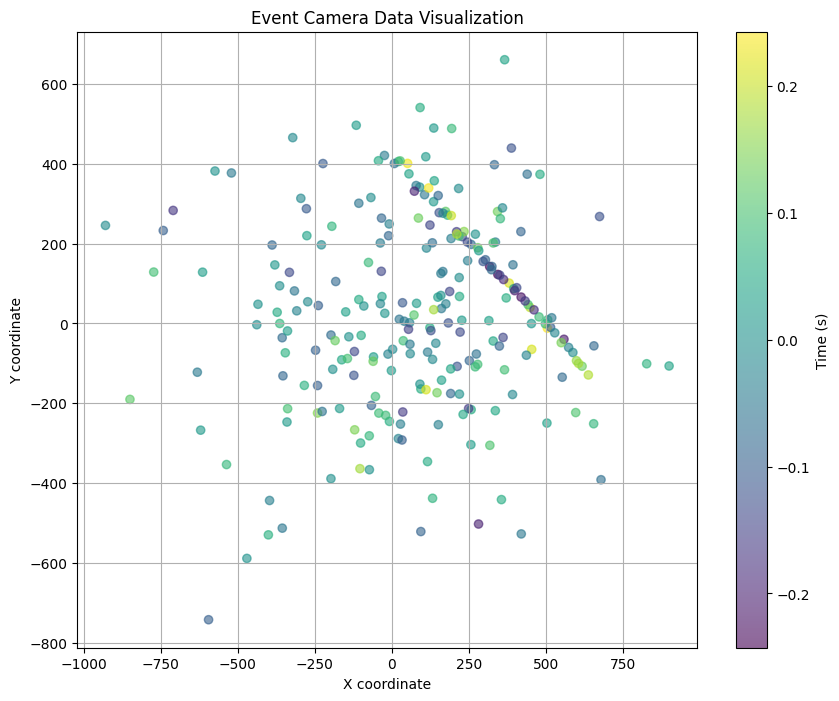

In [6]:
events_3 = load_events("hw5_data/data_package3.txt")
visualize_events(events_3)

In [122]:
def calculate_relative_pose(events):
    image_width = 640
    image_height = 480
    focal_length = 320
    
    angular_velocity = np.array([-0.242109, 0.0857362, 0.0507106])

    u0 = image_width / 2
    v0 = image_height / 2

    normalized_coords = np.zeros((events.shape[0], 3))
    normalized_coords[:, 0] = (events[:, 0] - u0) / focal_length
    normalized_coords[:, 1] = (events[:, 1] - v0) / focal_length
    normalized_coords[:, 2] = 1  # homogeneous coordinates

    time_diffs = events[:, 2] - 0  # ts = 0
    vs = np.array([np.array(angular_velocity)*time_diffs[i] for i in range(time_diffs.shape[0])])
    for i in range(vs.shape[0]):
        rot, _ = cv2.Rodrigues(vs[i])
        normalized_coords[i] = (rot @ normalized_coords[i].T).T
    
    time_diffs = time_diffs.reshape(-1, 1)

    A_all = np.hstack([time_diffs * normalized_coords, normalized_coords])

    # RANSAC parameters
    best = 0
    # best_R = np.identity(3)
    # best_u = [0, 0, 0]
    best_x_hat = None
    best_index = []
    for it in range(10000):
        
        A = A_all[np.random.choice(A_all.shape[0], size=5)]
        
        b = np.zeros((A.shape[0], 1))
        U, S, Vt = np.linalg.svd(A)
        
        x = Vt[-1, :].T
        
        #Eval
        test = A_all @ x.reshape(6,1)
        count = 0
        index = []
        for i, each in enumerate(test):
            if abs(each) <= 0.001:
                count += 1
                index.append(i)
        if count > best:
            best = count
            best_index = index
            best_x_hat = x
            # best_R = R
            # best_u = np.array([0, uy, uz])
            
    e_2 = best_x_hat[3:6]
    uz = best_x_hat[0:3] @ best_x_hat[3:6].T
    uy = np.linalg.norm(np.cross(best_x_hat[0:3], best_x_hat[3:6]))
    e_1 = np.cross(best_x_hat[0:3] ,best_x_hat[3:6]) / np.linalg.norm(np.cross(best_x_hat[0:3], best_x_hat[3:6]))
    e_3 = np.cross(e_1, e_2)
    R = np.vstack([e_1, e_2, e_3]).T
    u =  np.array([0, uy, uz])
    print(best_index)
    return u, R

In [124]:
result_3 = calculate_relative_pose(events_3)
result_3

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


(array([0.        , 0.31694905, 0.16697648]),
 array([[ 0.67654815, -0.57686383,  0.35709683],
        [-0.65838183, -0.6910552 , -0.0575918 ],
        [ 0.32987265, -0.19614243, -0.84732878]]))